In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import math
from itertools import product
import scipy.linalg
from scipy import optimize
import scipy.integrate as integrate
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
from scipy.misc import derivative
pd.options.mode.chained_assignment = None

In [3]:
E_acier = 210000 #MPa
E = 72000
rho = 2457 #kg/m3

In [4]:
class Trapez:
    def __init__(self, b1, b2, b, h, theta, t):
        self.b1 = b1
        self.b2 = b2
        self.b = b
        self.h = h
        self.theta = theta
        self.t = t
        yG1 = 0
        S1 = b1/2*t
        I1 = b1*t**3/24

        yG2 = h/2
        H = t/(2*np.cos(theta))
        S2 = h/np.tan(theta)*2*H
        I2 = 2*H*h/(3*np.tan(theta))*(h**2+H**2)-S2*yG2**2

        yG3 = h
        S3 = b2/2*t
        I3 = b2*t**3/24

        S = S1 + S2 + S3
        yG = (S1*yG1 + S2*yG2 + S3*yG3)/S
        Ix = I1+S1*(yG1)**2 + I2+S2*(yG2)**2 + I3+S3*(yG3)**2-S*yG**2
        self.I = Ix
        self.S = S
        self.yG = yG
        
    @classmethod
    def from_theta(cls, b1, b2, theta, b ,t):
        return cls(b1=b1, b2=b2, b=b, h=(b-b1-b2)*np.tan(theta)/2, theta=theta, t=t)
    @classmethod
    def from_h(cls, b1, b2, h, b ,t):
        return cls(b1=b1, b2=b2, b=b, h=h, theta=np.arctan(2*h/(b-b1-b2)), t=t)

    def __repr__(self):
        return (
            f"{self.__class__.__name__}"
            f"(b1={self.b1:.1f}mm, b2={self.b2:.1f}mm, b={self.b:.1f}mm, h={self.h:.1f}mm, theta={180/np.pi*self.theta:.1f}°, t={self.t:.2f}mm, S={self.S:.2f}mm2, I={self.I:.2f}mm4, yG={self.yG:.2f}mm)"
        )
    def contrainte_flexion(self, L, p):
        W = self.I/(self.h-self.yG)*10**(-9) #m3
        M = p*self.b/1000*L**2/8
        return M/W

    def deformation_trans_semelle(self,L,p):
        sigma = self.contrainte_flexion(L,p)
        bs = self.b2/2000
        z = (self.h - self.yG)/1000
        u = 2*sigma**2*bs**4/(E_acier**2*(self.t/1000)**2*z)
        return u*1000,u*1000/self.h*100 #mm

In [5]:
trapez1 = Trapez.from_h(b1=35, b2=75, b=175, h=25, t=0.75)
print(trapez1)
print(trapez1.deformation_trans_semelle(2,0.001))

Trapez(b1=35.0mm, b2=75.0mm, b=175.0mm, h=25.0mm, theta=37.6°, t=0.75mm, S=72.00mm2, I=7562.96mm4, yG=15.10mm)
(0.21119462567915162, 0.8447785027166066)


In [6]:
def circ_prop(r1,h,b,t):
    theta = 2*np.arctan((b-2*h)/(b+2*h))
    r2 = b/(2*np.cos(theta))-r1
    S = (r2+r1)*(np.pi/2-theta)*t
    A = (b/(2*np.cos(theta))-h)
    yG = ((t**3/12+t*r1**2)*np.cos(theta) - (t**3/12+t*r2**2)*np.cos(theta) + A*t*r2*(np.pi/2-theta))/S
    I = (-2*theta+np.sin(2*theta)+np.pi)*(t**3*r1+4*t*r1**3)/16+(-2*theta+np.sin(2*theta)+np.pi)*(t**3*r2+4*t*r2**3)/16 - 2*A*(t**3/12+t*r2**2)*np.cos(theta)+A**2*t*r2*(np.pi/2-theta)
    Ix = 2*(I - S*yG**2)
    return {'S': 2*S, 'yG': yG, 'I': Ix}

In [7]:
def sin_I(h,b,t):
    u = -t/2*np.sqrt(1+(b/(np.pi*h))**2)
    A1 = (b-4*u)*(np.sin(3*np.pi*b/(2-4*u))+9*np.cos(2*np.pi*u/(b-4*u)))/(24*np.pi)
    A2 = (b+4*u)*(np.sin(3*np.pi*b/(2+4*u))+9*np.cos(2*np.pi*u/(b+4*u)))/(24*np.pi)
    return (h**2*t/8+t**3/24)*(A1+A2)

In [8]:
data = pd.read_excel('sinus.xlsx')
data['I circ'] = data.apply(lambda row: circ_prop((row['b']**2+4*row['h']**2)/(16*row['h']),row['h'],row['b'],3)['I'],axis=1)
data['S circ'] = data.apply(lambda row: circ_prop((row['b']**2+4*row['h']**2)/(16*row['h']),row['h'],row['b'],3)['S'],axis=1)

data['ER I'] = data.apply(lambda row: -(row['I sin']-row['I circ'])/row['I sin'],axis=1)
data['ER I'] = data.apply(lambda row: row['ER I'] if row['b']  >= 0.536*row['h'] else float('nan'), axis=1)

data['I sin'] = data.apply(lambda row: row['I sin'] if row['b']  >= 0.536*row['h'] else float('nan'),axis=1)
data['I circ'] = data.apply(lambda row: row['I circ'] if row['b']  >= 0.536*row['h'] else float('nan'),axis=1)


data['ER S'] = data.apply(lambda row: -(row['S sin']-row['S circ'])/row['S sin'],axis=1)
data['ER S'] = data.apply(lambda row: row['ER S'] if row['b']  >= 0.536*row['h'] else float('nan'), axis=1)

In [9]:
data

h       b         I sin         S sin        I circ        S circ  \
0       10.0    10.0  7.607231e+02     69.733666  1.061211e+03     83.036154   
1       29.8    10.0           NaN    181.041244           NaN    258.205171   
2       49.6    10.0           NaN    294.468372           NaN    442.016551   
3       69.4    10.0           NaN    408.339478           NaN    627.370978   
4       89.2    10.0           NaN    522.481550           NaN    813.268867   
...      ...     ...           ...           ...           ...           ...   
2596   920.8  3000.0  1.053900e+09  10822.119437  1.218995e+09  11113.447896   
2597   940.6  3000.0  1.103900e+09  10892.179829  1.280418e+09  11199.520146   
2598   960.4  3000.0  1.155300e+09  10963.132419  1.343819e+09  11286.991544   
2599   980.2  3000.0  1.208100e+09  11034.956037  1.409234e+09  11375.841809   
2600  1000.0  3000.0  1.262300e+09  11107.630004  1.476701e+09  11466.050769   

          ER I      ER S  
0     0.395004  0.190761  
1          NaN       NaN  
2          NaN       NaN  
3          NaN       NaN  
4          NaN       NaN  
...        ...       ...  
2596  0.156652  0.026920  
2597  0.159904  0.028217  
2598  0.163177  0.029541  
2599  0.166488  0.030891  
2600  0.169850  0.032268  

[2601 rows x 8 columns]

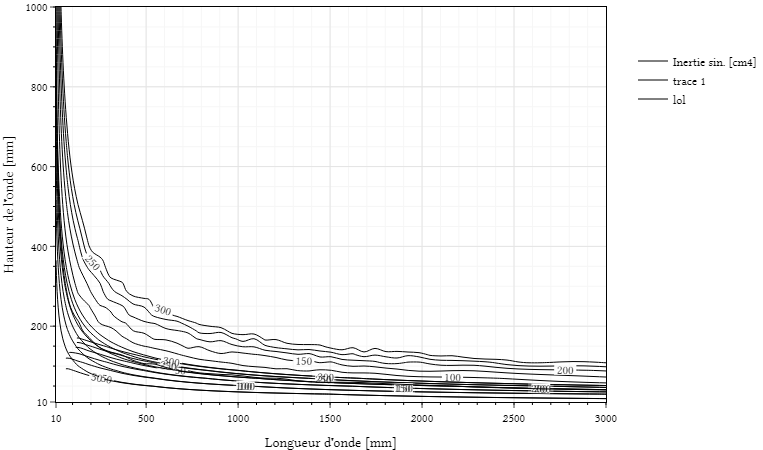

In [10]:
H = np.array(data['h'].drop_duplicates())
B = np.array(data['b'].drop_duplicates())
ER = np.array([np.array(data[data['h'] == h]['ER I']) for h in H])
I = np.array([np.array(data[data['h'] == h]['I sin']) for h in H])
fig = go.Figure()
fig.update_layout(width=500,height = 450,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1.05,y=0.9,xanchor="left"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Longueur d'onde [mm]",range=[10,3000],tickvals = [10,500,1000,1500,2000,2500,3000],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Hauteur de l'onde [mm]",range=[10,1000],tickvals = [10,200,400,600,800,1000],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=5, showgrid=True),tickmode = 'array',ticks="outside",
                 )

fig.add_trace(go.Contour(
    z=I/10**4,
    y=H,
    x=B,
    name="Inertie sin. [cm4]",
    contours=dict(start=0,size=50,end=300,
        showlabels = True,
    ),showlegend=True,showscale=False,line = dict(width = 1),contours_coloring='lines',colorscale=[[0, "rgb(0, 0, 0)"],[1, "rgb(0, 0, 0)"]]))

fig.add_trace(go.Contour(
    z=np.array([[b*3**3/12+b*3*h**2/8 for b in B] for h in H])/10**4,
    y=H,
    x=B,
    contours=dict(start=0,size=50,end=300,
        showlabels = True,
    ),showlegend=True,showscale=False,line = dict(width = 1),contours_coloring='lines',colorscale=[[0, "rgb(0, 0, 0)"],[1, "rgb(0, 0, 0)"]]
))
fig.add_trace(go.Contour(
    z=np.array([[sin_I(h,b,3) for b in B] for h in H])/10**4,
    y=H,
    x=B,
    contours=dict(start=0,size=50,end=300,
        showlabels = True,
    ),showlegend=True,name="lol",showscale=False,line = dict(width = 1),contours_coloring='lines',colorscale=[[0, "rgb(0, 0, 0)"],[1, "rgb(0, 0, 0)"]]
))
fig.write_image("plot.pdf")

fig.show()

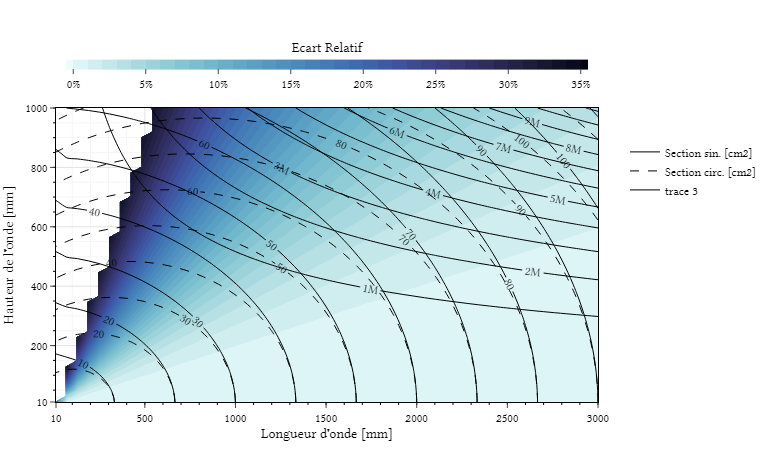

In [11]:
H = np.array(data['h'].drop_duplicates())
B = np.array(data['b'].drop_duplicates())
ER = np.array([np.array(data[data['h'] == h]['ER S']) for h in H])
fig = go.Figure()
fig.update_layout(width=500,height = 450,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1.05,y=0.9,xanchor="left"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Longueur d'onde [mm]",range=[10,3000],tickvals = [10,500,1000,1500,2000,2500,3000],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Hauteur de l'onde [mm]",range=[10,1000],tickvals = [10,200,400,600,800,1000],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=5, showgrid=True),tickmode = 'array',ticks="outside",
                 )

fig.add_trace(go.Contour(
    z=ER*100,
    y=H,
    x=B,
    contours=dict(start=0,size=1,end=35,
        showlabels = False,
    ),showlegend=False,showscale=True,line = dict(width = 0),colorbar=dict(title='Ecart Relatif',ticksuffix="%",titleside="top",tickmode="array", ticks="outside",orientation='h',len=1,thickness=10)
    ,colorscale="ice",reversescale=True
))

I = np.array([np.array(data[data['h'] == h]['S sin']) for h in H])

fig.add_trace(go.Contour(
    z=I/10**2,
    y=H,
    x=B,
    name="Section sin. [cm2]",
    contours=dict(
        showlabels = True,
    ),showlegend=True,showscale=False,line = dict(width = 1),contours_coloring='lines',colorscale=[[0, "rgb(0, 0, 0)"],[1, "rgb(0, 0, 0)"]]
))
I = np.array([np.array(data[data['h'] == h]['S circ']) for h in H])

fig.add_trace(go.Contour(
    z=I/10**2,
    y=H,
    x=B,
    name="Section circ. [cm2]",
    contours=dict(
        showlabels = True,
    ),showlegend=True,showscale=False,line = dict(width = 1,dash="dash"),contours_coloring='lines',colorscale=[[0, "rgb(0, 0, 0)"],[1, "rgb(0, 0, 0)"]]
))
fig.add_trace(go.Contour(
    z=np.array([[b*3**3/12+b*3*h**2/8 for b in B] for h in H])/10**2,
    y=H,
    x=B,
    contours=dict(
        showlabels = True,
    ),showlegend=True,showscale=False,line = dict(width = 1),contours_coloring='lines',colorscale=[[0, "rgb(0, 0, 0)"],[1, "rgb(0, 0, 0)"]]
))
fig.write_image("plot.pdf")

fig.show()

In [12]:
H = np.array(data['h'].drop_duplicates())
B = np.array(data['b'].drop_duplicates())
def find_nearest(array, value):     
    array = np.asarray(array)  
    idx = (np.abs(array - value)).argmin()     
    return idx
def S_fun(x,a,b,c):
    return a*np.cos(2*np.pi*x/b)+c
S_sin = np.array([np.array(data[data['h'] == h]['S sin']) for h in H])/100
S_circ = np.array([np.array(data[data['h'] == h]['S circ']) for h in H])/100
I_circ = np.array([np.array(data[data['h'] == h]['I circ']) for h in H])/10**4
I_sin = np.array([np.array(data[data['h'] == h]['I sin']) for h in H])/10**4
S_list = np.linspace(5,100,100)
B_list = [300,500,750,1000,1250,1500,2000,2500,3000]
df = pd.DataFrame(list(product(S_list,B_list)), columns=['S','b'])

def h_sin(row):
    p = plt.contour(B,H,S_sin, [row['S']]).get_paths()[0]
    plt.clf()
    x = p.vertices[:,0]
    y = p.vertices[:,1]
    P_sin = np.poly1d(np.polyfit(x, y, 5))
    h = P_sin(row['b'])
    if row['b']  >= 0.536*h and h > 0:
        return h
    else:
        return float('nan')
def h_circ(row):
    p = plt.contour(B,H,S_circ, [row['S']]).get_paths()[0]
    plt.clf()
    x = p.vertices[:,0]
    y = p.vertices[:,1]
    P_circ = np.poly1d(np.polyfit(x, y, 5))
    h = P_circ(row['b'])
    if row['b']  >= 0.536*h and h > 0:
        return h
    else:
        return float('nan')     
    
df['h sin'] = df.apply(h_sin,axis=1)
df['h circ'] = df.apply(h_circ,axis=1)
I_list = np.linspace(100,120000,1000)
poly_sin = []
poly_circ = []
k=0
for I in I_list:
    k+=1
    p = plt.contour(B,H,I_sin, [I]).get_paths()[0]
    plt.clf()
    x = p.vertices[:,0]
    y = p.vertices[:,1]
    P_sin = np.poly1d(np.polyfit(x, y, 5))
    poly_sin.append(P_sin)
    p = plt.contour(B,H,I_circ, [I]).get_paths()[0]
    plt.clf()
    x = p.vertices[:,0]
    y = p.vertices[:,1]
    P_circ = np.poly1d(np.polyfit(x, y, 5))
    poly_circ.append(P_circ)
    clear_output(wait=True)
    print(k)
    
def I_sin_fun(row):
    if row['b']  >= 0.536*row['h sin']:
        h_list = []
        for P in poly_sin:
            h_list.append(P(row['b']))
        k = find_nearest(h_list, row['h sin'])
        return I_list[k]
    return float('nan')
def I_circ_fun(row):
    if row['b']  >= 0.536*row['h circ']:
        h_list = []
        for P in poly_circ:
            h_list.append(P(row['b']))
        k = find_nearest(h_list, row['h circ'])
        return I_list[k]
    return float('nan')
df['I sin'] = df.apply(I_sin_fun,axis=1)
df['I circ'] = df.apply(I_circ_fun,axis=1)

df

1000


S     b        h sin       h circ          I sin         I circ
0      5.0   300          NaN          NaN            NaN            NaN
1      5.0   500          NaN          NaN            NaN            NaN
2      5.0   750          NaN          NaN            NaN            NaN
3      5.0  1000          NaN          NaN            NaN            NaN
4      5.0  1250          NaN          NaN            NaN            NaN
..     ...   ...          ...          ...            ...            ...
895  100.0  1250          NaN  1950.980068            NaN  120000.000000
896  100.0  1500  2371.544670  1431.138567  112078.678679  120000.000000
897  100.0  2000  1316.323860  1101.541042  112678.778779  120000.000000
898  100.0  2500  1023.411389   926.493461  115319.219219  109798.298298
899  100.0  3000   662.320916   622.452371   52188.688689   50868.468468

[900 rows x 6 columns]

<Figure size 640x480 with 0 Axes>

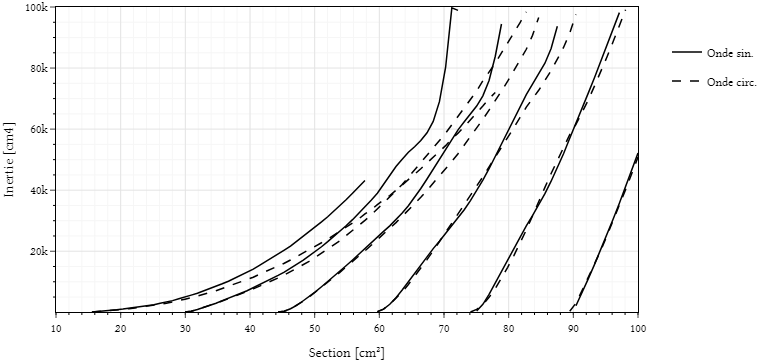

In [13]:
fig = go.Figure()
fig.update_layout(width=460,height = 350,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1.05,y=0.9,xanchor="left"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Section [cm²]",range=[10,100],tickvals = [5,10,20,30,40,50,60,70,80,90,100],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Inertie [cm4]",range=[100,100000],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=5, showgrid=True),tickmode = 'array',ticks="outside",
                 )

B_list = [500,1000,1500,2000,2500,3000]
show = True
for k in range(len(B_list)):
    b = B_list[k]
    subdf = df[df['b'] == b]
    x = [np.array(subdf['S'])[k] for k in range(len(subdf['S'])) if str(np.array(subdf['I sin'])[k]) != 'nan' and np.array(subdf['I sin'])[k] <= 100000]
    y = [np.array(subdf['I sin'])[k] for k in range(len(subdf['S'])) if str(np.array(subdf['I sin'])[k]) != 'nan' and np.array(subdf['I sin'])[k] <= 100000]
    fig.add_trace(go.Scatter(
        x=x,y=y,
        mode='lines',
        name='Onde sin.',
        line=dict(width=1.5,color='black'),showlegend=show,legendgroup='sin',
    ))
    x = [np.array(subdf['S'])[k] for k in range(len(subdf['S'])) if str(np.array(subdf['I circ'])[k]) != 'nan' and np.array(subdf['I circ'])[k] <= 100000]
    y = [np.array(subdf['I circ'])[k] for k in range(len(subdf['S'])) if str(np.array(subdf['I circ'])[k]) != 'nan' and np.array(subdf['I circ'])[k] <= 100000]
    fig.add_trace(go.Scatter(
        x=x,y=y,
        mode='lines',
        name='Onde circ.',
        line=dict(width=1.5,color='black',dash="dash"),showlegend=show,legendgroup='circ',
    ))
    show = False


fig.write_image("plot.pdf")

fig.show()

In [14]:
def len_sin(h,b,n):
    curve = lambda x: np.sqrt(1+(h*np.pi/b*np.sin(2*np.pi*x/b))**2)
    result = integrate.quad(curve,0,b)
    return result[0]*n
def moment_sin(w,h,b,n,L):
    l = len_sin(h,b,n)
    return w*l*L**2/8
def section_sin(h,b,n,t):
    l = len_sin(h,b,n)
    return l*t
def stress_sin(w,h,b,n,t,L,I):
    G = rho/100*L/2/1000
    M = moment_sin(w,h/1000,b/1000,n,L)/1000
    return M/(I/1000**4/(h/2000))
def depl_sin(w,h,b,n,t,L,I):
    l = len_sin(h,b,n)/1000
    p  = w*l/1000
    return 5*p*L**4/(384*E*I)

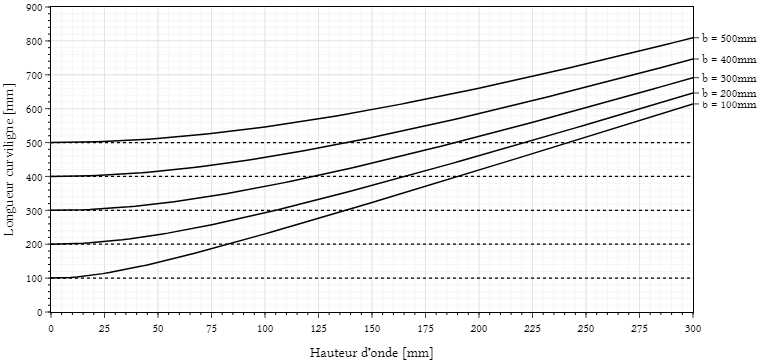

In [15]:

fig = go.Figure()
fig.update_layout(width=460,height = 350,plot_bgcolor='white',margin=dict(l=0, r=70, t=0, b=0),legend=dict(x=1.05,y=0.9,xanchor="left"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Hauteur d'onde [mm]",range=[0,300],tickvals = [0,25,50,75,100,125,150,175,200,225,250,275,300],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=20, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Longueur curviligne [mm]",range=[0,900],tickvals = [0,100,200,300,400,500,600,700,800,900],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=10, showgrid=True),tickmode = 'array',ticks="outside",
                 )
H = np.linspace(0,300,100)
for b in [100,200,300,400,500]:
    y= np.array([len_sin(h,b,1) for h in H])
    fig.add_trace(go.Scatter(
            x=H,y=y,
            mode='lines',
            name="{}".format(b),
            line=dict(width=1.5,color='black'),showlegend=show,legendgroup='circ',
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ))
    fig.add_annotation(
        x=300,
        y=y[-1],text="b = {}mm".format(b),
            showarrow=True,arrowhead=0,yanchor="middle",ax=5,ay=0,xanchor='left',
            yshift=0,xshift=1,bgcolor="white")
    fig.add_trace(go.Scatter(
            x=H,y=[b for h in H],
            mode='lines',
            name="{}".format(b),
            line=dict(width=1.2,color='black',dash="dot"),showlegend=show,legendgroup='circ',
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ))
fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

In [16]:
SW = pd.read_excel('FEM_simple.xlsx')

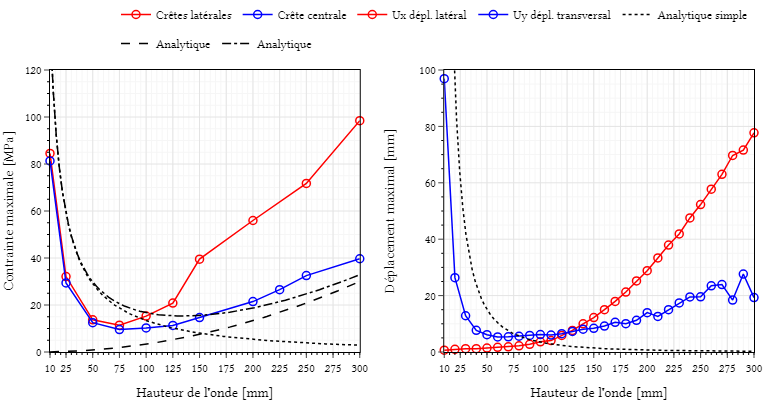

In [17]:
fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.12,    
    subplot_titles=())
fig.update_layout(width=750,height = 400,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1,y=1.25,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Hauteur de l'onde [mm]",range=[10,300],tickvals = [10,25,50,75,100,125,150,175,200,225,250,275,300],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=20, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=5, showgrid=True),tickmode = 'array',ticks="outside",
                 )
fig.update_yaxes(title_text="Contrainte maximale [MPa]",range=[0,120],col=1,row=1)
fig.update_yaxes(title_text="Déplacement maximal [mm]",range=[0,100],col=2,row=1)
"""
fig.add_trace(go.Scatter(
        x=[-1],y=[-1],
        mode='lines',
        name='Analytique',
        line=dict(width=1.5,color='black',dash="dot"),showlegend=True,legendgroup='ana',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)

fig.add_trace(go.Scatter(
        x=SW['h'],y=SW['stress'],
        mode='lines+markers',
        name='Contrainte maximale',
        line=dict(width=1.5,color='black'),showlegend=True,legendgroup='circ',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
"""

fig.add_trace(go.Scatter(
        x=[10,25,50,75,100,125,150,200,250,300],y=[84.49,32.09,13.69,11.39,15.28,20.82,39.52,55.96,71.71,98.44],
        mode='lines+markers',
        name='Crêtes latérales',
        line=dict(width=1.5,color='red'),showlegend=True,legendgroup='C',
    marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.add_trace(go.Scatter(
        x=[10,25,50,75,100,125,150,200,225,250,300],y=[81.31,29.37,12.49,9.567,10.22,11.3,14.66,21.45,26.53,32.52,39.68],
        mode='lines+markers',
        name='Crête centrale',
        line=dict(width=1.5,color='blue'),showlegend=True,legendgroup='C2',
    marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.add_trace(go.Scatter(
        x=SW['h'],y=SW['Ux'],
        mode='lines+markers',
        name='Ux dépl. latéral',
        line=dict(width=1.5,color='red'),showlegend=True,legendgroup='Ux',
    marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
    ),row=1,col=2)
fig.add_trace(go.Scatter(
        x=SW['h'],y=np.sqrt(SW['Ures']**2-SW['Ux']**2),
        mode='lines+markers',
        name='Uy dépl. transversal',
        line=dict(width=1.5,color='blue'),showlegend=True,legendgroup='Ures',
    marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
    ),row=1,col=2)

dataz = pd.read_excel('inertie_b300_t3.xlsx')
H = np.array(dataz['h'])/1000 #m
I = np.array(dataz['I'])/1000**4 #m4
l = np.array(dataz['S'])/3000 #m
w = 0.001 #MPa
L = 3 #m
M = w*0.3*L**2/8 #MNm

stress_flex = M/I*H/2 + 1.228/100*3 #MPa
disp_flex = 5*w*0.3*L**4/(384*E*I)*1000
fig.add_trace(go.Scatter(
        x=H*1000,y=stress_flex,
        mode='lines',
        name='Analytique simple',
        line=dict(width=1.5,color='black',dash="dot"),showlegend=True,legendgroup='ana',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.add_trace(go.Scatter(
        x=H*1000,y=disp_flex,
        mode='lines',
        name='Analytique simple',
        line=dict(width=1.5,color='black',dash="dot"),showlegend=False,legendgroup='ana',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),row=1,col=2)
stress_tors = 3*w*H**2/0.003**2
fig.add_trace(go.Scatter(
        x=H*1000,y=stress_tors,
        mode='lines',
        name='Analytique',
        line=dict(width=1.5,color='black',dash="dash"),showlegend=True,legendgroup='ana2',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.add_trace(go.Scatter(
        x=H*1000,y=stress_tors+stress_flex,
        mode='lines',
        name='Analytique',
        line=dict(width=1.5,color='black',dash="dashdot"),showlegend=True,legendgroup='ana3',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

In [18]:
f1 = pd.read_excel('force_lin1.xlsx')
f2 = pd.read_excel('force_lin2.xlsx')

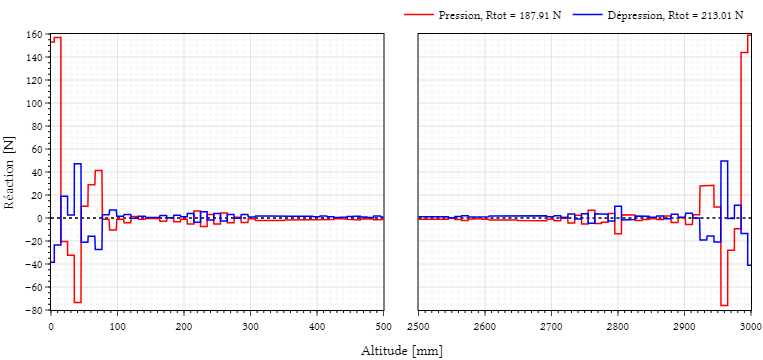

In [19]:
f1 = pd.read_excel('force_lin1.xlsx')
f2 = pd.read_excel('force_lin2.xlsx')
fig = make_subplots(
    rows=1, cols=2,
    shared_yaxes=True,
    horizontal_spacing=0.05,
    x_title='Altitude [mm]',
    subplot_titles=())
fig.update_annotations(font_size=14,font_family='Linux Libertine')


fig.update_layout(width=600,height = 350,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=50),legend=dict(x=1,y=1.125,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(range=[0,500],tickvals = np.arange(0,600,100),col=1,row=1,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=20, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Réaction [N]",range=[-80,160],tickvals = np.arange(-80,200,20),col=1,row=1,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=10, showgrid=True),tickmode = 'array',ticks="outside",
                 )
fig.update_yaxes(range=[-80,160],tickvals = np.arange(-80,200,20),col=2,row=1,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=0, tickcolor="black", nticks=10, showgrid=True),tickmode = 'array',
                 )
fig.update_xaxes(range=[2500,3000],tickvals = 2500+np.arange(0,600,100),col=2,row=1,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=20, tickmode='auto', showgrid=True),ticks="outside")
fig.add_trace(go.Scatter(
    x=[0,500],y=[0,0],
    mode='lines',
    name="dépression",
    line=dict(width=1.5,color='black',dash="dot"),showlegend=False,legendgroup='circ2',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8
),row=1,col=1)
fig.add_trace(go.Scatter(
    x=[2500,3000],y=[0,0],
    mode='lines',
    name="dépression",
    line=dict(width=1.5,color='black',dash="dot"),showlegend=False,legendgroup='circ2',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8
),row=1,col=2)
fig.add_trace(go.Scatter(
    x=np.array([[y+5,y-5] for y in f1['Y']]).flatten(),y=np.array([[f,f] for f in f1['Force']]).flatten(),
    mode='lines',
    name="Pression, Rtot = 187.91 N",
    line=dict(width=1.5,color='red'),showlegend=True,legendgroup='circ1',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
),row=1,col=1)
fig.add_trace(go.Scatter(
    x=np.array([[y+5,y-5] for y in f1['Y']]).flatten(),y=np.array([[f,f] for f in f1['Force']]).flatten(),
    mode='lines',
    name="{}".format(b),
    line=dict(width=1.5,color='red'),showlegend=show,legendgroup='circ1',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
),row=1,col=2)
fig.add_trace(go.Scatter(
    x=np.array([[y+5,y-5] for y in f2['Y']]).flatten(),y=np.array([[f,f] for f in f2['Force']]).flatten(),
    mode='lines',
    name="Dépression, Rtot = 213.01 N",
    line=dict(width=1.5,color='blue'),showlegend=True,legendgroup='circ2',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
),row=1,col=1)
fig.add_trace(go.Scatter(
    x=np.array([[y+5,y-5] for y in f2['Y']]).flatten(),y=np.array([[f,f] for f in f2['Force']]).flatten(),
    mode='lines',
    name="{}".format(b),
    line=dict(width=1.5,color='blue'),showlegend=show,legendgroup='circ2',
    marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
),row=1,col=2)
fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

In [20]:
d1 = []
d2 = []
L = [2,3,4,5,6]
for l in L:
    d = pd.read_excel('disp_lin1_{}.xlsx'.format(l))
    d = d.sort_values(by=['Y'])
    d1.append(d)
    d = pd.read_excel('disp_lin2_{}.xlsx'.format(l))
    d = d.sort_values(by=['Y'])
    d2.append(d)

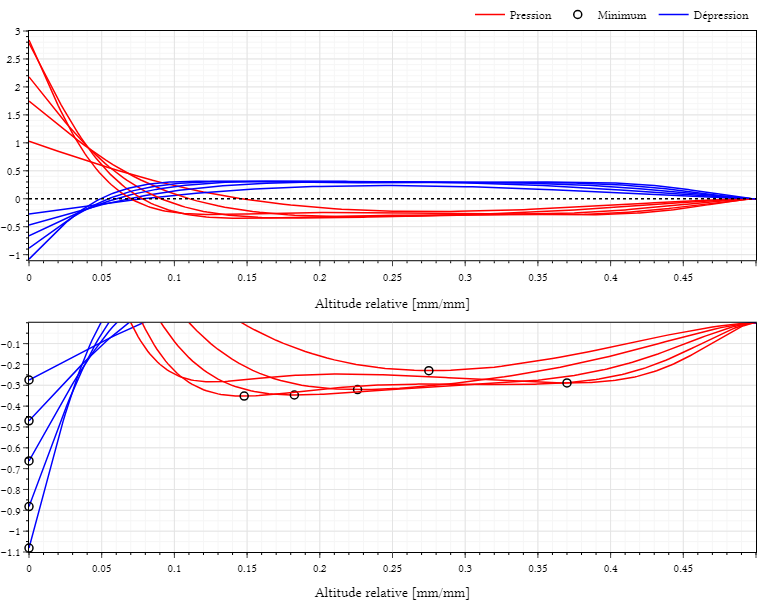

In [21]:
fig = make_subplots(
    rows=2, cols=1,
    vertical_spacing=0.12,
    y_title='Déplacement latéral [mm]',
    subplot_titles=())
fig.update_annotations(font_size=14,font_family='Linux Libertine')
fig.update_layout(width=375,height = 600,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1,y=1.06,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Altitude relative [mm/mm]",range=[0,0.5],tickvals = np.arange(0,0.7,0.05),col=1,row=2,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=20, tickmode='auto', showgrid=True),ticks="outside")
fig.update_xaxes(title_text="Altitude relative [mm/mm]",range=[0,0.5],tickvals = np.arange(0,0.7,0.05),col=1,row=1,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=20, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(range=[-1.1,3],tickvals = np.arange(-5,5,0.5),col=1,row=1,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=10, showgrid=True),tickmode = 'array',ticks="outside",
                 )
fig.update_yaxes(range=[-1.1,0],tickvals = np.arange(-1.1,0,0.1),col=1,row=2,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=10, showgrid=True),tickmode = 'array',ticks="outside",
                 )
show = True
press_y_min = []
dpress_y_min = []
for k in range(len(L)):
    l = L[k]
    d = d1[k]
    d = d[d['Y'] <= l*1000/2]
    fig.add_trace(go.Scatter(
        x=d['Y']/(l*1000),y=-d['Ux'],
        mode='lines',
        name="Pression",
        line=dict(width=1.5,color='red'),showlegend=show,legendgroup=k,
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),col=1,row=2)
    fig.add_trace(go.Scatter(
        x=d['Y']/(l*1000),y=-d['Ux'],
        mode='lines',
        name="Pression",
        line=dict(width=1.5,color='red'),showlegend=False,legendgroup=k,
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),col=1,row=1)
    y_min = np.min(-d['Ux'])
    x_min = np.array([d[d['Ux'] == -y_min]['Y']/(l*1000)]).flatten()[0]
    press_y_min.append(y_min)
    fig.add_trace(go.Scatter(
        x=[x_min],y=[y_min],
        mode='markers',
        name="Minimum",
        line=dict(width=1,color='black'),showlegend=show,legendgroup="10"+str(k),
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),col=1,row=2)
    
    d = d2[k]
    d = d[d['Y'] <= l*1000/2]
    fig.add_trace(go.Scatter(
        x=d['Y']/(l*1000),y=-d['Ux'],
        mode='lines',
        name="Dépression",
        line=dict(width=1.5,color='blue'),showlegend=show,legendgroup="b",
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),col=1,row=2)
    fig.add_trace(go.Scatter(
        x=d['Y']/(l*1000),y=-d['Ux'],
        mode='lines',
        name="Pression",
        line=dict(width=1.5,color='blue'),showlegend=False,legendgroup=k,
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),col=1,row=1)
    y_min = np.min(-d['Ux'])
    x_min = np.array([d[d['Ux'] == -y_min]['Y']/(l*1000)]).flatten()[0]
    dpress_y_min.append(y_min)
    fig.add_trace(go.Scatter(
        x=[x_min],y=[y_min],
        mode='markers',
        name="Minimum",
        line=dict(width=1,color='black'),showlegend=False,legendgroup="10"+str(k),
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),col=1,row=2)
    show=False
fig.add_trace(go.Scatter(
        x=[0,0.5],y=[0,0],
        mode='lines',
        name="Minimum",
        line=dict(width=1.5,color='black',dash="dot"),showlegend=False,legendgroup="10"+str(k),
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
    ),col=1,row=1)
fig.update_traces(cliponaxis=False)

fig.write_image("plot.pdf")

fig.show()

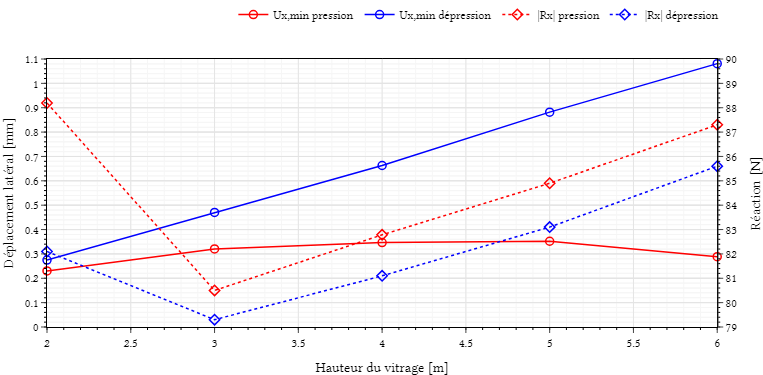

In [22]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(width=400,height = 375,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=0.95,y=1.22,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Hauteur du vitrage [m]",range=[2,6],tickvals = np.arange(2,6.5,0.5),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")

fig.update_yaxes(title_text="Déplacement latéral [mm]",range=[0,1.1],tickvals = np.arange(0,1.2,0.1), secondary_y=False,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                 )
fig.update_yaxes(title_text="Réaction [N]",range=[79,90],tickvals = np.linspace(79,90,12), secondary_y=True,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                 )
fig.add_trace(go.Scatter(
        x=L,y=-np.array(press_y_min),
        mode='lines+markers',
        name="Ux,min pression",
        line=dict(width=1.5,color='red'),showlegend=True,legendgroup="1",
        marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
    ), secondary_y=False,)
fig.add_trace(go.Scatter(
        x=L,y=-np.array(dpress_y_min),
        mode='lines+markers',
        name="Ux,min dépression",
        line=dict(width=1.5,color='blue'),showlegend=True,legendgroup="2",
        marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
    ), secondary_y=False,)

fig.add_trace(go.Scatter(
        x=L,y=[88.195,80.5,82.783,84.9,87.3],
        mode='lines+markers',
        name="|Rx| pression",
        line=dict(width=1.5,color='red',dash="dot"),showlegend=True,legendgroup="3",
        marker_symbol=102,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
    ), secondary_y=True,)
fig.add_trace(go.Scatter(
        x=L,y=[82.1,79.3,81.1,83.1,85.6],
        mode='lines+markers',
        name="|Rx| dépression",
        line=dict(width=1.5,color='blue',dash="dot"),showlegend=True,legendgroup="4",
        marker_symbol=102,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
    ), secondary_y=True,)
fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

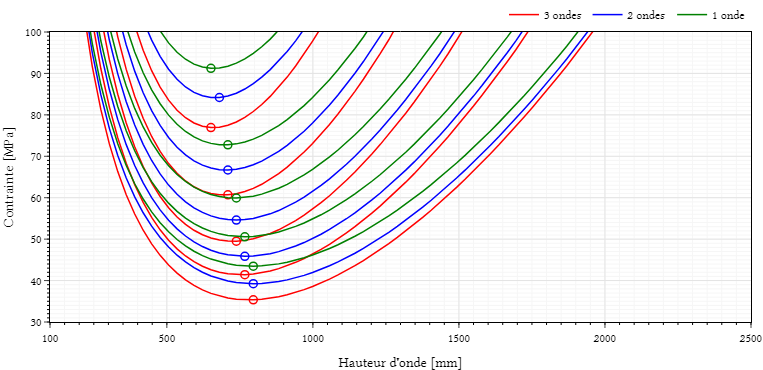

In [23]:
data = pd.read_excel('inertie_b1000.xlsx')
data['stress'] = data.apply(lambda row: 1.5*0.006*row['b']/1000*10**2/(16*row['I']/1000**4)*row['h']/1000+1.35*1.228/100*10+1.5*0.006*row['h']**2/row['t']**2,axis=1)
fig = go.Figure()
fig.update_layout(width=370,height = 370,plot_bgcolor='white',margin=dict(l=0, r=00, t=0, b=0),legend=dict(x=1.0,y=1.11,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Hauteur d'onde [mm]",range=[100,2500],tickvals =[100,500,1000,1500,2000,2500,3000],
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=20, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Contrainte [MPa]",range=[30,100],tickvals = np.arange(0,110,10),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                 )
h_min_1000 = []
S_1000 = []
stress_1000 =[]
H = np.array(data['h'].drop_duplicates())
T = np.array(data['t'].drop_duplicates())

show = True
for t in T:
    d = data[data['t'] == t]
    x = d['h']
    y = d['stress']
    y_min = np.min(y)
    h_min_1000.append(np.min(d[d['stress'] == y_min]['h']))
    S_1000.append(3*np.min(d[d['stress'] == y_min]['S']))
    stress_1000.append(y_min)
    fig.add_trace(go.Scatter(
            x=x,y=y,
            mode='lines',
            name="3 ondes",
            line=dict(width=1.5,color='red'),showlegend=show,legendgroup='circ',
        marker_symbol=100,marker_line_color="red", marker_color="black",marker_line_width=1.5, marker_size=8,
        ))
    fig.add_trace(go.Scatter(
            x=[np.min(d[d['stress'] == y_min]['h'])],y=[y_min],
            mode='markers',
            name=str(t),
            line=dict(width=1.5,color='red'),showlegend=False,legendgroup='circ',
        marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
        ))
    show = False
    
data = pd.read_excel('inertie_b1500.xlsx')
data['stress'] = data.apply(lambda row: 1.5*0.006*row['b']/1000*10**2/(16*row['I']/1000**4)*row['h']/1000+1.35*1.228/100*10+1.5*0.006*row['h']**2/row['t']**2,axis=1)
h_min_1500 = []
S_1500 = []
stress_1500 =[]
H = np.array(data['h'].drop_duplicates())
show=True
for t in T:
    d = data[data['t'] == t]
    x = d['h']
    y = d['stress']
    y_min = np.min(y)
    h_min_1500.append(np.min(d[d['stress'] == y_min]['h']))
    S_1500.append(2*np.min(d[d['stress'] == y_min]['S']))
    stress_1500.append(y_min)
    fig.add_trace(go.Scatter(
            x=x,y=y,
            mode='lines',
            name="2 ondes",
            line=dict(width=1.5,color='blue'),showlegend=show,legendgroup='circ2',
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ))
    fig.add_trace(go.Scatter(
            x=[np.min(d[d['stress'] == y_min]['h'])],y=[y_min],
            mode='markers',
            name=str(t),
            line=dict(width=1.5,color='blue'),showlegend=False,legendgroup='circ2',
        marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
        ))
    show = False

data = pd.read_excel('inertie_b3000.xlsx')
data['stress'] = data.apply(lambda row: 1.5*0.006*row['b']/1000*10**2/(16*row['I']/1000**4)*row['h']/1000+1.35*1.228/100*10+1.5*0.006*row['h']**2/row['t']**2,axis=1)
h_min_3000 = []
S_3000 = []
stress_3000 = []
H = np.array(data['h'].drop_duplicates())
show=True
for t in T:
    d = data[data['t'] == t]
    x = d['h']
    y = d['stress']
    y_min = np.min(y)
    h_min_3000.append(np.min(d[d['stress'] == y_min]['h']))
    S_3000.append(np.min(d[d['stress'] == y_min]['S']))
    stress_3000.append(y_min)
    fig.add_trace(go.Scatter(
            x=x,y=y,
            mode='lines',
            name="1 onde",
            line=dict(width=1.5,color='green'),showlegend=show,legendgroup='circ3',
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ))
    fig.add_trace(go.Scatter(
            x=[np.min(d[d['stress'] == y_min]['h'])],y=[y_min],
            mode='markers',
            name=str(t),
            line=dict(width=1.5,color='blue'),showlegend=False,legendgroup='circ2',
        marker_symbol=100,marker_line_color="green", marker_color="green",marker_line_width=1.5, marker_size=8,
        ))
    show = False
fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

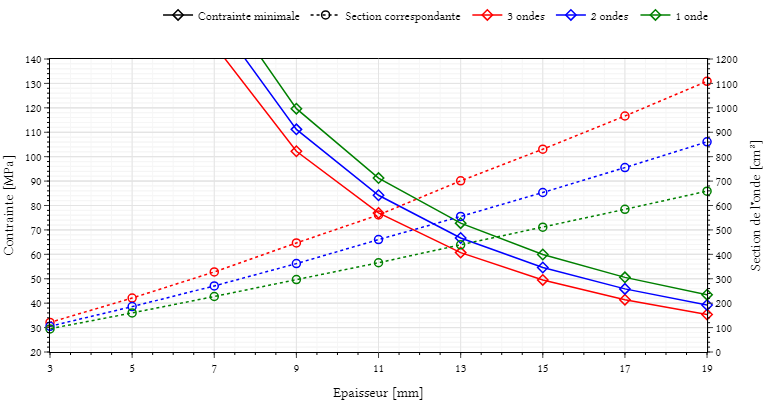

In [24]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.update_layout(width=420,height = 400,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=0.95,y=1.2,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Epaisseur [mm]",range=[3,19],tickvals =np.arange(3,21,2),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Section de l'onde [cm²]",range=[0,1200],tickvals =np.arange(0,1300,100), secondary_y=True,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                 )
fig.update_yaxes(title_text="Contrainte [MPa]",range=[20,140],tickvals = np.arange(20,150,10),secondary_y=False,
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                 )
fig.add_trace(go.Scatter(
            x=[-1,-1],y=[-1,-1],
            mode='lines+markers',
            name="Contrainte minimale",
            line=dict(width=1.5,color='black'),showlegend=True,legendgroup='2',
        marker_symbol=102,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ),secondary_y=False)
fig.add_trace(go.Scatter(
            x=[-1,-1],y=[-1,-1],
            mode='lines+markers',
            name="Section correspondante",
            line=dict(width=1.5,color='black',dash="dot"),showlegend=True,legendgroup='1',
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ),secondary_y=True)

fig.add_trace(go.Scatter(
            x=T,y=np.array(S_1000)/10**2,
            mode='lines+markers',
            name="b = 1000mm",
            line=dict(width=1.5,color='red',dash="dot"),showlegend=False,legendgroup='circ',
        marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
        ),secondary_y=True)
fig.add_trace(go.Scatter(
            x=T,y=np.array(S_1500)/10**2,
            mode='lines+markers',
            name="b = 1500mm",
            line=dict(width=1.5,color='blue',dash="dot"),showlegend=False,legendgroup='circ2',
        marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
        ),secondary_y=True)
fig.add_trace(go.Scatter(
            x=T,y=np.array(S_3000)/10**2,
            mode='lines+markers',
            name="b = 3000mm",
            line=dict(width=1.5,color='green',dash="dot"),showlegend=False,legendgroup='circ3',
        marker_symbol=100,marker_line_color="green", marker_color="green",marker_line_width=1.5, marker_size=8,
        ),secondary_y=True)

fig.add_trace(go.Scatter(
            x=T,y=np.array(stress_1000),
            mode='lines+markers',
            name="3 ondes",
            line=dict(width=1.5,color='red'),showlegend=True,legendgroup='circ1',
        marker_symbol=102,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
        ),secondary_y=False)
fig.add_trace(go.Scatter(
            x=T,y=np.array(stress_1500),
            mode='lines+markers',
            name="2 ondes",
            line=dict(width=1.5,color='blue'),showlegend=True,legendgroup='circ12',
        marker_symbol=102,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
        ),secondary_y=False)
fig.add_trace(go.Scatter(
            x=T,y=np.array(stress_3000),
            mode='lines+markers',
            name="1 onde",
            line=dict(width=1.5,color='green'),showlegend=True,legendgroup='circ13',
        marker_symbol=102,marker_line_color="green", marker_color="green",marker_line_width=1.5, marker_size=8,
        ),secondary_y=False)


fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

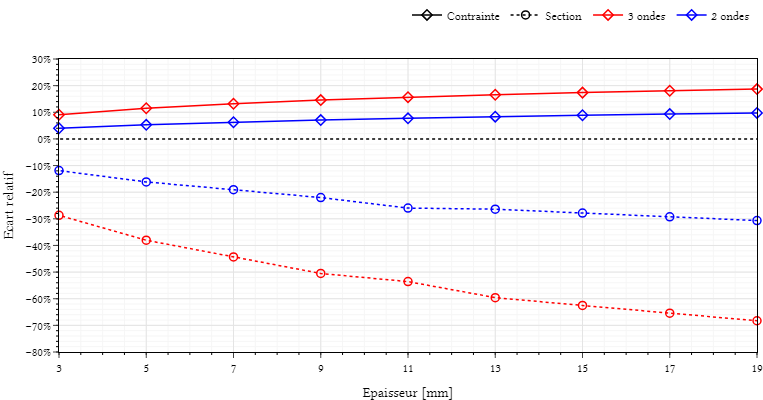

In [25]:
fig = go.Figure()

fig.update_layout(width=370,height = 400,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1,y=1.2,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Epaisseur [mm]",range=[3,19],tickvals =np.arange(3,21,2),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Ecart relatif",range=[-0.8,0.3],tickvals =np.arange(-1,1.1,0.1), tickformat=".0%",
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                )
SER_1000 = (np.array(S_3000)-np.array(S_1000))/np.array(S_3000)
SER_1500 = (np.array(S_3000)-np.array(S_1500))/np.array(S_3000)
stressER_1000 = (np.array(stress_3000)-np.array(stress_1000))/np.array(stress_3000)
stressER_1500 = (np.array(stress_3000)-np.array(stress_1500))/np.array(stress_3000)
fig.add_trace(go.Scatter(
            x=[-1,-1],y=[-1,-1],
            mode='lines+markers',
            name="Contrainte",
            line=dict(width=1.5,color='black'),showlegend=True,legendgroup='2',
        marker_symbol=102,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ))
fig.add_trace(go.Scatter(
            x=[-1,-1],y=[-1,-1],
            mode='lines+markers',
            name="Section",
            line=dict(width=1.5,color='black',dash="dot"),showlegend=True,legendgroup='1',
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ))
fig.add_trace(go.Scatter(
            x=[0,19],y=[0,0],
            mode='lines',
            name="Section correspondante",
            line=dict(width=1.5,color='black',dash="dot"),showlegend=False,legendgroup='1',
        marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
        ))
fig.add_trace(go.Scatter(
            x=T,y=SER_1000,
            mode='lines+markers',
            name="b = 1000mm",
            line=dict(width=1.5,color='red',dash="dot"),showlegend=False,legendgroup='circ',
        marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
        ))
fig.add_trace(go.Scatter(
            x=T,y=SER_1500,
            mode='lines+markers',
            name="b = 1500mm",
            line=dict(width=1.5,color='blue',dash="dot"),showlegend=False,legendgroup='circ2',
        marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
        ))

fig.add_trace(go.Scatter(
            x=T,y=stressER_1000,
            mode='lines+markers',
            name="3 ondes",
            line=dict(width=1.5,color='red'),showlegend=True,legendgroup='circ1',
        marker_symbol=102,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
        ))
fig.add_trace(go.Scatter(
            x=T,y=stressER_1500,
            mode='lines+markers',
            name="2 ondes",
            line=dict(width=1.5,color='blue'),showlegend=True,legendgroup='circ12',
        marker_symbol=102,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
        ))


fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

In [26]:
data = pd.read_excel('dim.xlsx')
data['fstress'] = data.apply(lambda row: float(row['fstress'].split(" ")[0].replace(",",".")),axis=1)
data['tstress'] = data.apply(lambda row: float(row['tstress'].split(" ")[0].replace(",",".")),axis=1)
data['fdisp'] = data.apply(lambda row: float(row['fdisp'].split(" ")[0].replace(",",".")),axis=1)
data['tdisp'] = data.apply(lambda row: float(row['tdisp'].split(" ")[0].replace(",",".")),axis=1)

d = data[data['t']%2==0]

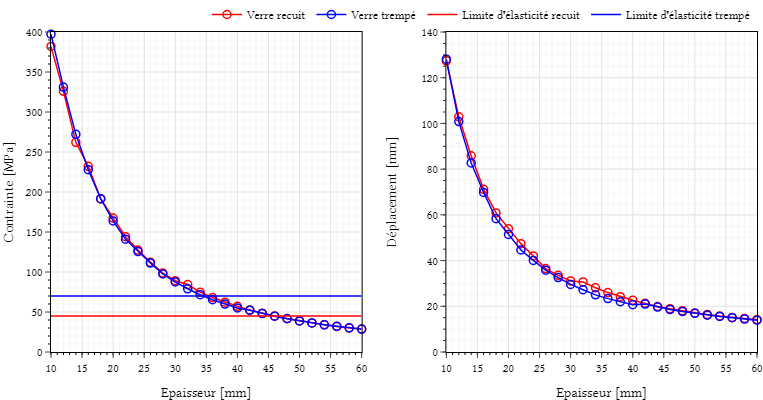

In [27]:
fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.12,    
    subplot_titles=())
fig.update_layout(width=750,height = 400,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1,y=1.1,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Epaisseur [mm]",range=[10,60],tickvals =np.arange(10,100,5),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=20, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Contrainte [MPa]",range=[0,400],col=1,row=1,showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",
                 minor=dict(ticklen=2, tickcolor="black",nticks=5, showgrid=True),tickmode = 'array',ticks="outside",
                 )
fig.update_yaxes(title_text="Déplacement [mm]",range=[0,140],tickvals =np.arange(0,200,20),col=2,row=1,showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",
                 minor=dict(ticklen=2, tickcolor="black", nticks=10, showgrid=True),tickmode = 'array',ticks="outside",
                 )

fig.add_trace(go.Scatter(
        x=d['t'],y=d['fstress'],
        mode='lines+markers',
        name="Verre recuit",
        line=dict(width=1.5,color='red'),showlegend=True,legendgroup='C',
    marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.add_trace(go.Scatter(
        x=d['t'],y=d['tstress'],
        mode='lines+markers',
        name="Verre trempé",
        line=dict(width=1.5,color='blue'),showlegend=True,legendgroup='C2',
    marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.add_trace(go.Scatter(
        x=d['t'],y=d['fdisp'],
        mode='lines+markers',
        name="Verre recuit",
        line=dict(width=1.5,color='red'),showlegend=False,legendgroup='Ux',
    marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
    ),row=1,col=2)
fig.add_trace(go.Scatter(
       x=d['t'],y=d['tdisp'],
        mode='lines+markers',
        name="Verre trempé",
        line=dict(width=1.5,color='blue'),showlegend=False,legendgroup='Ures',
    marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
    ),row=1,col=2)
fig.add_trace(go.Scatter(
       x=[0,60],y=[45,45],
        mode='lines',
        name="Limite d'élasticité recuit",
        line=dict(width=1.5,color='red'),showlegend=True,legendgroup='Ures',
    marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.add_trace(go.Scatter(
       x=[0,60],y=[70,70],
        mode='lines',
        name="Limite d'élasticité trempé",
        line=dict(width=1.5,color='blue'),showlegend=True,legendgroup='Ures2',
    marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
    ),row=1,col=1)
fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

In [28]:
data1 = pd.read_excel('joint1.xlsx').sort_values(by=['Z'])
data2 = pd.read_excel('joint3.xlsx').sort_values(by=['Z'])

Z1 = np.array(data1['Z'].drop_duplicates())
Z2 = np.array(data2['Z'].drop_duplicates())

stress1 = np.array([np.max(data1[data1['Z'] == z]['stress']) for z in Z1])
stress2 = np.array([np.max(data2[data2['Z'] == z]['stress']) for z in Z2])

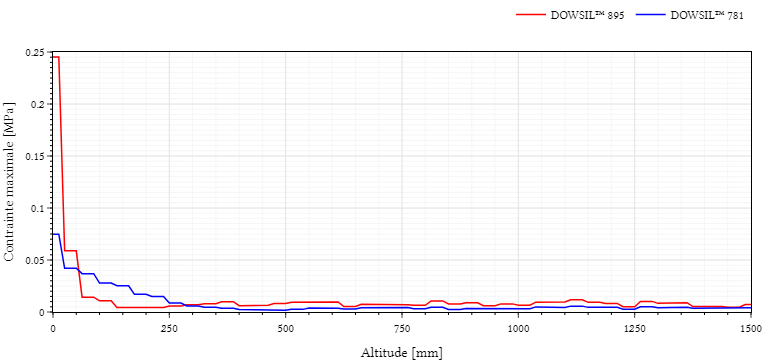

In [29]:
fig = go.Figure()

fig.update_layout(width=370,height = 350,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1,y=1.2,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Altitude [mm]",range=[0,1500],tickvals =np.arange(0,2000,250),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Contrainte maximale [MPa]",range=[0,0.25],tickvals =np.arange(0,1.1,0.05),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                )


fig.add_trace(go.Scatter(
            x=np.array([[z-12.5,z+12.5]for z in Z1]).flatten(),y=np.array([[s,s] for s in stress1]).flatten(),
            mode='lines',
            name="DOWSIL™ 895",
            line=dict(width=1.5,color='red'),showlegend=True,legendgroup='circ',
        marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
        ))
fig.add_trace(go.Scatter(
            x=np.array([[z-12.5,z+12.5]for z in Z2]).flatten(),y=np.array([[s,s] for s in stress2]).flatten(),
            mode='lines',
            name="DOWSIL™ 781",
            line=dict(width=1.5,color='blue'),showlegend=True,legendgroup='circ2',
        marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
        ))

fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

In [30]:
Y = []
stress = []
L = [3000,2750,2500,2250,2000,1500,1000,500]
for l in L: 
    data = pd.read_excel('joint{}.xlsx'.format(l)).sort_values(by=['Y'])
    Y1 = np.array(data['Y'].drop_duplicates())
    Y.append(Y1)
    stress.append(np.array([np.max(data[data['Y'] == y]['stress']) for y in Y1]))

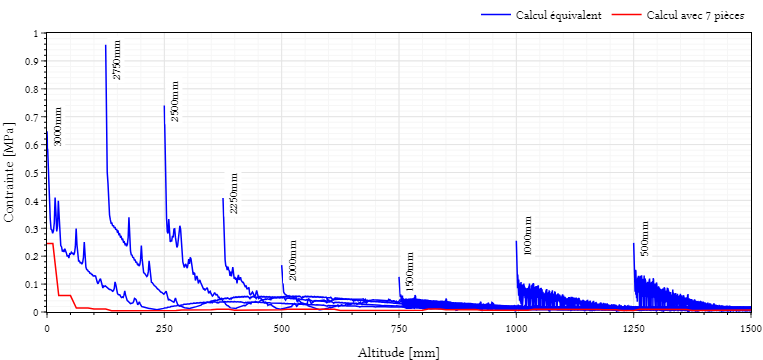

In [31]:
fig = go.Figure()

fig.update_layout(width=370,height = 350,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1,y=1.12,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Altitude [mm]",range=[0,1500],tickvals =np.arange(0,2000,250),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Contrainte [MPa]",range=[0,1],tickvals =np.arange(0,2,0.1),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                )
show=True
maxstress = []
for k in range(len(stress)):
    x = Y[k]
    y = stress[k]
    fig.add_trace(go.Scatter(
                x=x,y=y,
                mode='lines',
                name="Calcul équivalent",
                line=dict(width=1.5,color='blue'),showlegend=show,legendgroup=str(L[k]),
            marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
            ))
    if y[0]>0.8:
        yshift = -15
    else:
        yshift = +5
    fig.add_annotation(
        x=max(0,x[0]),
        y=y[0],text="{}mm".format(L[k]),
            showarrow=False,arrowhead=0,yanchor="middle",ax=5,ay=0,xanchor='left',textangle=-90,
            yshift=yshift,xshift=1,bgcolor="white")
    maxstress.append(y[0])
    show=False
fig.add_trace(go.Scatter(
            x=np.array([[z-12.5,z+12.5]for z in Z1]).flatten(),y=np.array([[s,s] for s in stress1]).flatten(),
            mode='lines',
            name="Calcul avec 7 pièces",
            line=dict(width=1.5,color='red'),showlegend=True,legendgroup='circ2',
        marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
        ))
fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

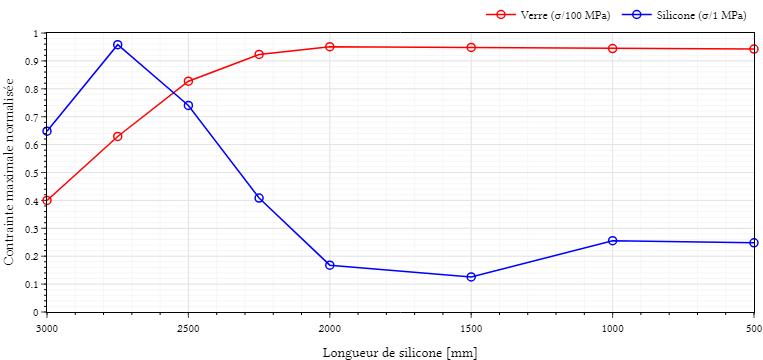

In [32]:
fig = go.Figure()

fig.update_layout(width=370,height = 350,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1,y=1.12,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Longueur de silicone [mm]",range=[3000,500],tickvals =np.arange(0,8000,500),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Contrainte maximale normalisée ",range=[0,1],tickvals =np.arange(0,2,0.1),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=20, showgrid=True),tickmode = 'array',ticks="outside",
                )
show=True
fig.add_trace(go.Scatter(
                x=L,y=np.array([39.99,62.92,82.72,92.32,95.08,94.84,94.41,94.24])/100,
                mode='lines+markers',
                name="Verre (σ/100 MPa)",
                line=dict(width=1.5,color='red'),showlegend=show,legendgroup="1",
            marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
            ))
fig.add_trace(go.Scatter(
                x=L,y=maxstress,
                mode='lines+markers',
                name="Silicone (σ/1 MPa)",
                line=dict(width=1.5,color='blue'),showlegend=show,legendgroup="2",
            marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
            ))

fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()

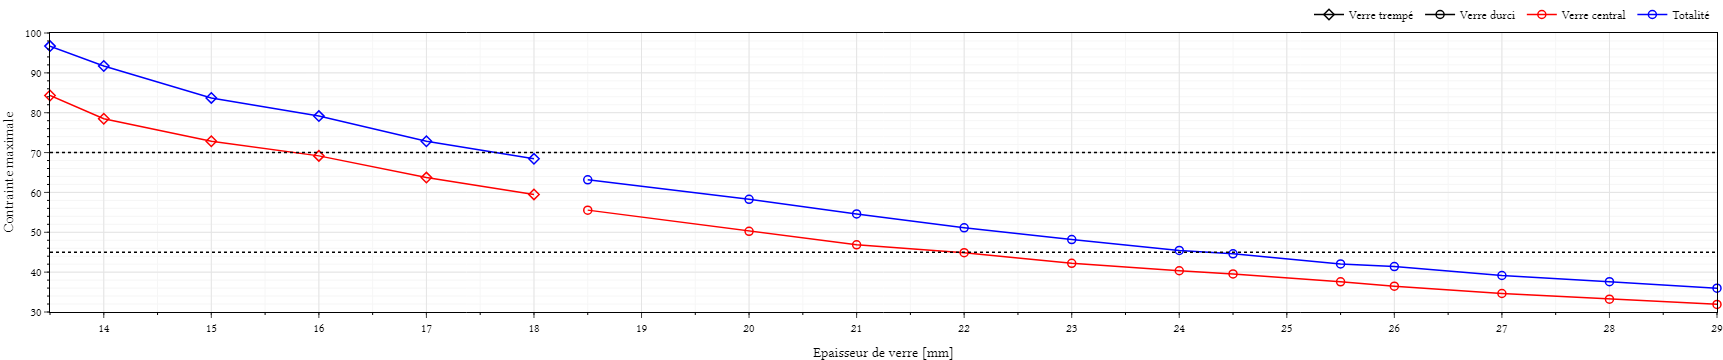

In [145]:
fig = go.Figure()

fig.update_layout(width=370,height = 350,plot_bgcolor='white',margin=dict(l=0, r=0, t=0, b=0),legend=dict(x=1,y=1.12,xanchor="right",orientation="h"),font=dict(family='Linux Libertine',color='black'),coloraxis_showscale=False)
fig.update_xaxes(title_text="Epaisseur de verre [mm]",range=[13.5,29],tickvals =np.arange(0,10000,1),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black",nticks=10, tickmode='auto', showgrid=True),ticks="outside")
fig.update_yaxes(title_text="Contrainte maximale",range=[30,100],tickvals =np.arange(0,200,10),
                 showline=True,showgrid=True,gridcolor='rgb(228,228,228)',linecolor='black',mirror=True,tickson="boundaries",minor=dict(ticklen=2, tickcolor="black", nticks=10, showgrid=True),tickmode = 'array',ticks="outside",
                )
show=True
data = pd.read_excel('dim_float.xlsx')
fig.add_trace(go.Scatter(
                x=[-1],y=[-1],
                mode='lines+markers',
                name="Verre trempé",
                line=dict(width=1.5,color='black'),showlegend=True,legendgroup="9",
            marker_symbol=102,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
            ))
fig.add_trace(go.Scatter(
                x=[-1],y=[-1],
                mode='lines+markers',
                name="Verre durci",
                line=dict(width=1.5,color='black'),showlegend=True,legendgroup="8",
            marker_symbol=100,marker_line_color="black", marker_color="black",marker_line_width=1.5, marker_size=8,
            ))
fig.add_trace(go.Scatter(
                x=data['t'],y=data['central'],
                mode='lines+markers',
                name="Verre central",
                line=dict(width=1.5,color='red'),showlegend=show,legendgroup="1",
            marker_symbol=100,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
            ))
fig.add_trace(go.Scatter(
                x=data['t'],y=data['global'],
                mode='lines+markers',
                name="Totalité",
                line=dict(width=1.5,color='blue'),showlegend=show,legendgroup="2",
            marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
            ))
fig.add_trace(go.Scatter(
                x=[13.5,30],y=[45,45],
                mode='lines',
                name="Totalité",
                line=dict(width=1.5,color='black',dash="dot"),showlegend=False,legendgroup="2",
            marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
            ))
show=False
data = pd.read_excel('dim_trempe.xlsx')

fig.add_trace(go.Scatter(
                x=data['t'],y=data['central'],
                mode='lines+markers',
                name="Verre central",
                line=dict(width=1.5,color='red'),showlegend=show,legendgroup="1",
            marker_symbol=102,marker_line_color="red", marker_color="red",marker_line_width=1.5, marker_size=8,
            ))
fig.add_trace(go.Scatter(
                x=data['t'],y=data['global'],
                mode='lines+markers',
                name="Totalité",
                line=dict(width=1.5,color='blue'),showlegend=show,legendgroup="2",
            marker_symbol=102,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
            ))
fig.add_trace(go.Scatter(
                x=[13.5,30],y=[70,70],
                mode='lines',
                name="Totalité",
                line=dict(width=1.5,color='black',dash="dot"),showlegend=False,legendgroup="2",
            marker_symbol=100,marker_line_color="blue", marker_color="blue",marker_line_width=1.5, marker_size=8,
            ))

fig.update_traces(cliponaxis=False)
fig.write_image("plot.pdf")

fig.show()